In [ ]:
setwd('/home/kl467102/thesis')
getwd()
R.version

[1] "/home/kl467102/thesis"

               _                           
platform       x86_64-conda-linux-gnu      
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          4.2                         
year           2024                        
month          10                          
day            31                          
svn rev        87279                       
language       R                           
version.string R version 4.4.2 (2024-10-31)
nickname       Pile of Leaves              

In [ ]:
library(cicero)
library(monocle3)
library(Matrix)


Loading required package: monocle3

Loading required package: Biobase

Loading required package: BiocGenerics




Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The 

### scATAC data loading

In [ ]:
dataset_name = 'pbmc10k'
prefix = ''
data_dir = '/home/kl467102/thesis/data/pbmc10k/peaks_only'


In [ ]:
data_folder <- data_dir

output_folder <- paste0("results/cicero_output/", dataset_name)
if (!dir.exists(output_folder)) {
  dir.create(output_folder, recursive = TRUE)
}
output_folder

[1] "results/cicero_output/pbmc10k"

This comes from 10x summary

Reference path	
/mnt/scratch2/cellranger-arc-2.0.0/refdata-cellranger-arc-GRCh38-2020-A-2.0.0

In [ ]:
chrom_sizes_file <- '/home/kl467102/thesis/data/ARC/refdata-cellranger-arc-GRCh38-2020-A-2.0.0/star/chrNameLength.txt'

In [ ]:
in_mtx <- paste0(data_folder, "/", prefix, "matrix.mtx.gz")
in_barcodes <- paste0(data_folder, "/", prefix, "barcodes.tsv.gz")
in_bed <- paste0(data_folder, "/", prefix, "peaks.bed.gz")

### data processing, create CDS object

In [ ]:
# Read in matrix data using the Matrix package
indata <- Matrix::readMM(in_mtx) 
# Binarize the matrix
indata@x[indata@x > 0] <- 1


In [ ]:
# Format cell info
cellinfo <- read.table(in_barcodes, header = FALSE)
#cellinfo$V1 <- gsub(".*_", "", cellinfo$V1)
row.names(cellinfo) <- cellinfo$V1
names(cellinfo) <- "cells"


In [ ]:
# Format peak info
peakinfo <- read.table(in_bed)
names(peakinfo) <- c("chr", "bp1", "bp2")
peakinfo$site_name <- paste(peakinfo$chr, peakinfo$bp1, peakinfo$bp2, sep="_")
row.names(peakinfo) <- peakinfo$site_name

row.names(indata) <- row.names(peakinfo)
colnames(indata) <- row.names(cellinfo)

# Make CDS
input_cds <-  suppressWarnings(new_cell_data_set(indata,
cell_metadata = cellinfo,
gene_metadata = peakinfo))

input_cds <- monocle3::detect_genes(input_cds)

#Ensure there are no peaks included with zero reads
input_cds <- input_cds[Matrix::rowSums(exprs(input_cds)) != 0,] 

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



###  Qauality check and Filtering


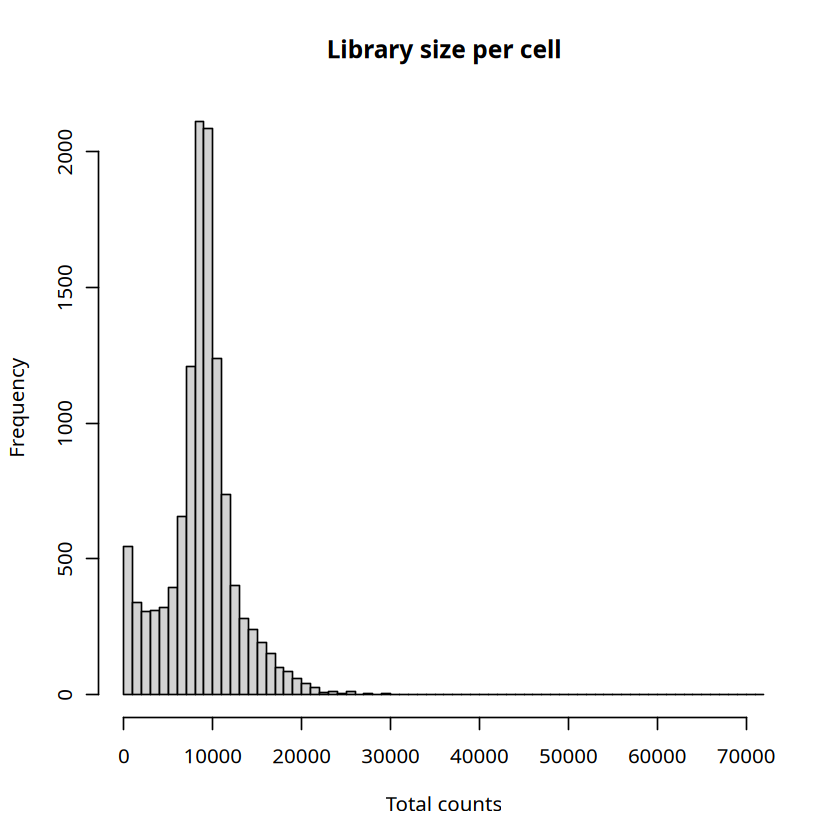

In [ ]:
# Plot number of peaks per cell
total_counts <- Matrix::colSums(exprs(input_cds))
hist(total_counts, breaks = 100, main = "Library size per cell", xlab = "Total counts")

In [ ]:
max_count <-  30000
min_count <- 1000
input_cds <- input_cds[,Matrix::colSums(exprs(input_cds)) >= min_count] 
input_cds <- input_cds[,Matrix::colSums(exprs(input_cds)) <= max_count] 


### Process cicero-CDS object

In [ ]:
# Data preprocessing
set.seed(420)

input_cds <- detect_genes(input_cds)
input_cds <- estimate_size_factors(input_cds)
input_cds <- preprocess_cds(input_cds, method = "LSI")

# Dimensional reduction with umap
input_cds <- reduce_dimension(input_cds, reduction_method = 'UMAP', 
                              preprocess_method = "LSI")
umap_coords <- reducedDims(input_cds)$UMAP


cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = umap_coords)



Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 0.237775780910213
Median shared cells bin-bin: 0



In [ ]:
# Save Cds object (Optional)
saveRDS(cicero_cds, paste0(output_folder, "/", "cicero_cds.Rds"))


In [ ]:
chromosome_length <- read.table(chrom_sizes_file)


In [ ]:
conns <- run_cicero(cicero_cds, chromosome_length) # Takes a few minutes to run


In [ ]:

# Save results (Optional)
saveRDS(conns, paste0(output_folder, "/", "cicero_connections.Rds"))

# Check results
head(conns)


,Peak1,Peak2,coaccess
,<chr>,<fct>,<dbl>
1,GL000194.1_100988_101878,GL000194.1_27943_28829,0
2,GL000194.1_100988_101878,GL000194.1_55799_56585,0
4,GL000194.1_100988_101878,GL000194.1_114521_115378,0
5,GL000194.1_114521_115378,GL000194.1_27943_28829,0
6,GL000194.1_114521_115378,GL000194.1_55799_56585,0
7,GL000194.1_114521_115378,GL000194.1_100988_101878,0


In [ ]:
all_peaks <- row.names(exprs(input_cds))
write.csv(x = all_peaks, file = paste0(output_folder, "/", "all_peaks.csv"))
write.csv(x = conns, file = paste0(output_folder, "/","cicero_connections.csv"))


In [ ]:
length(all_peaks)

[1] 143887